In [1]:
import functools

import numpy as np

import torch
from typing import Dict, List, Optional,  Union, Callable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pyro
import pyro.distributions as dist

import random

from causal_pyro.indexed.ops import IndexSet, gather, indices_of, scatter
from causal_pyro.interventional.handlers import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual, Preemptions

In [2]:
class HalpernPearlModifiedApproximate:

    def __init__(
        self, 
        model: Callable,
        antecedents: Union[Dict[str, torch.Tensor], List[str]],
        outcome: str,
        witness_candidates: List[str],
        observations: Optional[Dict[str, torch.Tensor]],
        sample_size: int = 100,
        event_dim: int = 0
        ):
        
        self.model = model
        self.antecedents = antecedents
        self.outcome = outcome
        self.witness_candidates = witness_candidates
        self.nodes = antecedents + [outcome] + witness_candidates
        self.observations = observations
        self.sample_size = sample_size

        self.antecedents_dict = (
            self.antecedents if isinstance(self.antecedents, dict)
            else self.revert_antecedents(self.antecedents)
        )
    
        self.preemptions = {candidate: functools.partial(self.preempt_with_factual,
                                             antecedents = self.antecedents) for 
                                             candidate in self.witness_candidates}
        

    @staticmethod
    def revert_antecedents(antecedents: List[str]) -> Dict[str, Callable[[torch.Tensor], torch.Tensor]]:
        return {antecedent: (lambda v: 1 - v) for antecedent in antecedents}

    @staticmethod   
    def preempt_with_factual(value: torch.Tensor, *,
                          antecedents: List[str] = None, event_dim: int = 0):
    
        if antecedents is None:
            antecedents = []

        antecedents = [a for a in antecedents if a in indices_of(value, event_dim=event_dim)]

        factual_value = gather(value, IndexSet(**{antecedent: {0} for antecedent in antecedents}),
                                event_dim=event_dim)
            
        return scatter({
            IndexSet(**{antecedent: {0} for antecedent in antecedents}): factual_value,
            IndexSet(**{antecedent: {1} for antecedent in antecedents}): factual_value,
        }, event_dim=event_dim)
        
        
    def __call__(self, *args, **kwargs):
        with pyro.poutine.trace() as trace:
            with MultiWorldCounterfactual():
                with do(actions=self.antecedents_dict):
                    with Preemptions(actions = self.preemptions):
                        with pyro.condition(data={k: torch.as_tensor(v) for k, v in self.observations.items()}):
                            with pyro.plate("plate", self.sample_size):
                                self.consequent = self.model()[self.outcome]
                                self.intervened_consequent = gather(self.consequent, IndexSet(**{ant: {1} for ant in self.antecedents}))
                                self.observed_consequent = gather(self.consequent, IndexSet(**{ant: {0} for ant in self.antecedents}))
                                self.consequent_differs = self.intervened_consequent != self.observed_consequent   
                                pyro.factor("consequent_differs", torch.where(self.consequent_differs, torch.tensor(0.0), torch.tensor(-1e8)))
                            
        self.trace = trace.trace
        self.nodes_trace = {node: self.trace.nodes[node]['value'] for node in self.nodes}
        
        
         # slightly hacky solution for odd witness candidate sets
        if  isinstance(self.consequent_differs.squeeze().tolist(), bool):
            self.existential_but_for = self.consequent_differs.squeeze()
        else:
            #if (len(self.consequent_differs.squeeze().tolist() )>1):
            self.existential_but_for = any(self.consequent_differs.squeeze().tolist()                )  


        witness_dict = dict()
        if self.witness_candidates:
            witness_keys = ["__split_" + candidate for candidate in self.witness_candidates]
            witness_dict = {key: self.trace.nodes[key]['value']  for key in witness_keys}
            

        witness_dict['observed'] = self.observed_consequent.squeeze()
        witness_dict['intervened'] = self.intervened_consequent.squeeze()
        witness_dict['consequent_differs'] = self.consequent_differs.squeeze()

        # slightly hacky as above
        self.witness_df = pd.DataFrame(witness_dict) if self.witness_candidates else witness_dict

        if self.witness_candidates:
            self.witness_df['witness_size'] = self.witness_df[witness_keys].sum(axis = 1)
            satisfactory = self.witness_df[self.witness_df['consequent_differs'] == True]
            
        self.minimal_witness_size = satisfactory['witness_size'].min() if self.witness_candidates else 0
        self.responsibility_internal = 1/(len(self.antecedents) + self.minimal_witness_size)


In [3]:
class HalpernPearlResponsibilityApproximate:

    def __init__(
        self, 
        model: Callable,
        nodes: List,
        antecedent: str,
        outcome: str,
        observations: Dict[str, torch.Tensor], 
        runs_n: int 
    ):
        self.model = model
        self.nodes = nodes
        self.antecedent = antecedent
        self.outcome = outcome
        self.observations = observations
        self.runs_n = runs_n
        
        self.minimal_antecedents_cache = []
        self.antecedent_sizes = []
        self.existential_but_fors = []
        self.minimal_witness_sizes = []
        self.responsibilities = []
        self.HPMs = []

    def __call__(self):
        
        for step in range(1,self.runs_n):

            nodes = self.nodes
            if self.outcome in nodes:
                nodes.remove(self.outcome) 
            
            companion_size = random.randint(0,len(nodes))
            companion_candidates = random.sample(self.nodes, companion_size)
            witness_candidates = [node for node in self.nodes if 
                                node != self.antecedent and 
                                node != self.outcome and 
                                    node not in companion_candidates]

            HPM = HalpernPearlModifiedApproximate(
                model = self.model,
                antecedents = companion_candidates,
                outcome = self.outcome,
                witness_candidates = witness_candidates,
                observations = self.observations,
                sample_size = 1000)
            
            HPM()

            self.HPMs.append(HPM)


            if  HPM.existential_but_for:


                subset_in_cache = any([s.issubset(set(HPM.antecedents)) for s in self.minimal_antecedents_cache])
                if not subset_in_cache:
                    self.minimal_antecedents_cache.append(set(HPM.antecedents))

                    if self.antecedent in HPM.antecedents:
                        self.antecedent_sizes.append(len(HPM.antecedents))
                        self.existential_but_fors.append(HPM.existential_but_for)
                        self.minimal_witness_sizes.append(HPM.minimal_witness_size)
                        self.responsibilities.append(HPM.responsibility_internal)


        self.denumerators = [x + y for x, y in zip(self.antecedent_sizes, self.minimal_witness_sizes)]

        self.responsibilityDF = pd.DataFrame(
            {"existential_but_for": [bool(value) for value in self.existential_but_fors],
                "antecedent_size": self.antecedent_sizes, 
                "minimal_witness_size": self.minimal_witness_sizes,
                "denumerator": self.denumerators,
                "responsibility": self.responsibilities
            }
            )
        if len(self.responsibilityDF['existential_but_for']) == 0:
            self.responsibility = 0
        else:
            min_denumerator = min(self.responsibilityDF['denumerator'])
            self.responsibility = 1/min_denumerator

 

In [4]:
def firing_squad_model():
    probs = pyro.sample("probs", dist.Dirichlet(torch.ones(5)))

    who_has_bullet = pyro.sample("who_has_bullet", dist.OneHotCategorical(probs))

    mark0 = pyro.deterministic("mark0", torch.tensor([who[0] for who in who_has_bullet]), event_dim=0)
    mark1 = pyro.deterministic("mark1", torch.tensor([who[1] for who in who_has_bullet]), event_dim=0)
    mark2 = pyro.deterministic("mark2", torch.tensor([who[2] for who in who_has_bullet]), event_dim=0)
    mark3 = pyro.deterministic("mark3", torch.tensor([who[3] for who in who_has_bullet]), event_dim=0)
    mark4 = pyro.deterministic("mark4", torch.tensor([who[4] for who in who_has_bullet]), event_dim=0)

    dead = pyro.deterministic("dead", mark0 + mark1 + mark2 + mark3 + 
                                mark4  > 0)
    
    return {"probs": probs,
            "mark0": mark0,
            "mark1": mark1,
            "mark2": mark2,

            "mark3": mark3,
            "mark4": mark4, 
            "dead": dead}

In [5]:
# Halpern's strategy: assign weights to models
# and take the weighted average

pyro.set_rng_seed(102)

marksman0_responsibilities = []
for who in range(0,5):
    probs = torch.zeros(5)
    probs[who] = 1.0


    responsibility_marksmen_HPR = HalpernPearlResponsibilityApproximate(
        model = firing_squad_model,
        nodes = ["mark" + str(i) for i in range(0,5)],
        antecedent = "mark0", outcome = "dead",
        observations = {"probs": probs,},
                        runs_n=50)

    responsibility_marksmen_HPR()
    marksman0_responsibilities.append(responsibility_marksmen_HPR.responsibility)

weights = torch.full((5,), .2)

# if your pr(mark0) = i, 
# the blame in this case is i as well 

print(torch.dot(torch.tensor(marksman0_responsibilities), weights))

tensor(0.2000)


## Blame for voters

The general phenomenon in the voting setup: if $a$ voted for and $b$ against, $a>b$, a voter voting for has degree of responsibility $\frac{1}{\lceil (a-b)/2\rceil}$. So much is in Halpern. Now let's go beyond, what if you decide whether to vote and consider your blame if your candidate looses and you didn't vote? Still a somewhat simplistic setup: eight other people are about to vote, each outcome among them you consider equally likely, and you consider the blame associated with you skipping the voting if your candidate fails.

In [6]:
def choose_to_vote_model():
    u_a = pyro.sample("u_a", dist.Categorical(logits=torch.ones(8)))
    u_skip = pyro.sample("u_skip", dist.Bernoulli(0.5))

    a = pyro.deterministic("a", u_a, event_dim=0)
    skip = pyro.deterministic("skip", u_skip, event_dim=0)

    result = pyro.deterministic("result", 
                            (a + 1 - skip) > torch.ceil(9 - skip)/2)

    return {"a": a, "against": 8-a, "voted": 1 - skip, "result": result}

In [7]:
choose_to_vote_model()

{'a': tensor(0),
 'against': tensor(8),
 'voted': tensor(1.),
 'result': tensor(False)}

In [8]:
# your skipping is not an actual cause if a=1

skipping1HPM = HalpernPearlModifiedApproximate(
    model = choose_to_vote_model,
    antecedents = ["skip"],
    outcome = "result",
    witness_candidates = ["a"],
    observations = dict(u_a=1.),
    sample_size = 100)

skipping1HPM()

skipping1HPM.existential_but_for

False

In [9]:
# but it is, if a = 4
skipping4HPM = HalpernPearlModifiedApproximate(
    model = choose_to_vote_model,
    antecedents = ["skip"],
    outcome = "result",
    witness_candidates = ["a"],
    observations = dict(u_a=4.),
    sample_size = 100)

skipping4HPM()

skipping4HPM.existential_but_for

True

In [10]:
# with this model responsibilities follow the same pattern

skipping1HPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_model,
    nodes = ["a", "skip"],
    antecedent = "skip", outcome = "result",
    observations = dict(u_a=1.), 
    runs_n=50
    )

skipping1HPR()
skipping1HPR.responsibility

0

In [11]:
pyro.set_rng_seed(102)
skipping4HPR = HalpernPearlResponsibilityApproximate(
    model = choose_to_vote_model,
    nodes = ["a", "skip"],
    antecedent = "skip", outcome = "result",
    observations = dict(u_a=4.), 
    runs_n=50
    )

skipping4HPR()
print(
skipping4HPR.responsibilityDF,
skipping4HPR.responsibility
)

   existential_but_for  antecedent_size  minimal_witness_size  denumerator  \
0                 True                2                     0            2   
1                 True                1                     0            1   

   responsibility  
0             0.5  
1             1.0   1.0


In [12]:
# but now suppose we work with a wide model

def choosing_to_vote_wide_model():
    u_vote0 = pyro.sample("u_vote0", dist.Bernoulli(0.6))
    u_vote1 = pyro.sample("u_vote1", dist.Bernoulli(0.6))
    u_vote2 = pyro.sample("u_vote2", dist.Bernoulli(0.6))
    u_vote3 = pyro.sample("u_vote3", dist.Bernoulli(0.6))
    u_vote4 = pyro.sample("u_vote4", dist.Bernoulli(0.6))
    u_vote5 = pyro.sample("u_vote5", dist.Bernoulli(0.6))
    u_vote6 = pyro.sample("u_vote6", dist.Bernoulli(0.6))
    u_vote7 = pyro.sample("u_vote7", dist.Bernoulli(0.6))
    u_skip = pyro.sample("u_skip", dist.Bernoulli(0.5))

    vote0 = pyro.deterministic("vote0", u_vote0, event_dim=0)
    vote1 = pyro.deterministic("vote1", u_vote1, event_dim=0)
    vote2 = pyro.deterministic("vote2", u_vote2, event_dim=0)
    vote3 = pyro.deterministic("vote3", u_vote3, event_dim=0)
    vote4 = pyro.deterministic("vote4", u_vote4, event_dim=0)
    vote5 = pyro.deterministic("vote5", u_vote5, event_dim=0)
    vote6 = pyro.deterministic("vote6", u_vote6, event_dim=0)
    vote7 = pyro.deterministic("vote7", u_vote7, event_dim=0)
    skip = pyro.deterministic("skip", u_skip, event_dim=0)


    outcome = pyro.deterministic("outcome", vote0 + vote1 + vote2 + vote3 + 
                                 vote4 + vote5 + vote6 + vote7 + 1 - skip > 4)
    return {"outcome": outcome.float()}

choosing_to_vote_wide_model()

{'outcome': tensor(1.)}

In [13]:
# if a = 1, skipping is still not an actual cause

skipping_wide1HPM = HalpernPearlModifiedApproximate(
    model = choosing_to_vote_wide_model,
    antecedents = ["skip"],
    outcome = "outcome",
    witness_candidates = [f"vote{i}" for i in range(0,8)],
    observations = dict(u_vote0=1., u_vote1=0., u_vote2=0.,
                        u_vote3=0., u_vote4=0., u_vote5=0,
                        u_vote6=0., u_vote7=0.),
    sample_size = 1000)

skipping_wide1HPM()
skipping_wide1HPM.existential_but_for


False

In [14]:
# if a = 4, skipping is  an actual cause

skipping_wide4HPM = HalpernPearlModifiedApproximate(
    model = choosing_to_vote_wide_model,
    antecedents = ["skip"],
    outcome = "outcome",
    witness_candidates = [f"vote{i}" for i in range(0,8)],
    observations = dict(u_vote0=1., u_vote1=1., u_vote2=1.,
                        u_vote3=1., u_vote4=0., u_vote5=0,
                        u_vote6=0., u_vote7=0.),
    sample_size = 1000)

skipping_wide4HPM()
skipping_wide4HPM.existential_but_for


True

In [15]:
# if a = 1 your responsibility is now 1/4
# because if you voted for
# and three other voters changed their mind
# the outcome would be different

skipping_wide1HPR = HalpernPearlResponsibilityApproximate(
    model = choosing_to_vote_wide_model,
    nodes = [f"vote{i}" for i in range(0,8,)] + ["skip"],
    antecedent = "skip", outcome = "outcome",
    observations =  dict(u_vote0=1., u_vote1=0., u_vote2=0.,
                        u_vote3=0., u_vote4=0., u_vote5=0,
                        u_vote6=0., u_vote7=0.), 
    runs_n=500
    )

skipping_wide1HPR()
skipping_wide1HPR.responsibility

0.25

The above illustrates one reason why what Halpern called the naive definition of responsibility used in Halpern is properly so named: it is highly sensitive to modeling choices and needs to be improved. This is a story for another occasion. Meawhile, let's assume that the wide model is the intended one and see what can be said about blame for failure before the voting happens.

In [16]:
# for a>4 blame is zero as your candidate wins

pyro.set_rng_seed(1231)

skipping_responsibilities = []

for a in range(0,5):

    observations = {"u_vote"+str(i): 1. if i < a else 0. for i in range(0,8)}

    skipping_wide_stepHPR = HalpernPearlResponsibilityApproximate(
    model = choosing_to_vote_wide_model,
    nodes = [f"vote{i}" for i in range(0,8,)] + ["skip"],
    antecedent = "skip", outcome = "outcome",
    observations =  observations, 
    runs_n=100
    )
    skipping_wide_stepHPR()

    skipping_responsibilities.append(skipping_wide_stepHPR.responsibility)

skipping_responsibilities 
# [0.2, 0.25, 0.3333333333333333, 0.3333333333333333, 1.0]

[0.2, 0.25, 0.3333333333333333, 0.3333333333333333, 1.0]

In [17]:
# assuming each value of a has probability 1/8
# the expected value of responsibility for failure 
# if you skip the voting

print(
sum([1/8 * resp for resp in skipping_responsibilities])
)

# 0.26458333333333334

0.26458333333333334


## Pollution example

In the original example, company A dumps either 0 or 100 kilograms of pollutant, company B dumps either 60 or 0 kilograms, and biologists determine that k kilograms of pollutant sufﬁce for the ﬁsh to die. 
One “problematic” case is was when k = 80 and both companies dump pollutants. In this case, only A is a cause of the ﬁsh dying according to the modiﬁed HP deﬁnition. 

We'll go a bit further: we consider a situation in which the amount that companies have to potentially dump and the threshold come from normal distributions. 


In [18]:
amount_A = 100
amount_B = 60

def pollution_model():
    u_A_dumps = pyro.sample("u_A_dumps", dist.Bernoulli(0.5))
    u_B_dumps = pyro.sample("u_B_dumps", dist.Bernoulli(0.5))
    u_k = pyro.sample("u_k", dist.Normal(80., 10.))

    A_dumps = pyro.deterministic("A_dumps", u_A_dumps, event_dim=0)
    B_dumps = pyro.deterministic("B_dumps", u_B_dumps, event_dim=0)
    k = pyro.deterministic("k", u_k, event_dim=0)

    total_pollution = pyro.deterministic("total_pollution",
                                          A_dumps * amount_A + B_dumps * amount_B)
    dead = pyro.deterministic("dead", total_pollution > k)

    return {"total_pollution": total_pollution, "k": k, "dead": dead}

pollution_model()

{'total_pollution': tensor(100.), 'k': tensor(56.6922), 'dead': tensor(True)}

In [19]:
# A an actual cause in the original scenario
# B not an actual cause in the original scenario


pollution_strict_A_HPM = HalpernPearlModifiedApproximate(
    model = pollution_model,
    antecedents = ["A_dumps"],
    outcome = "dead",
    witness_candidates = ["B_dumps"],
    observations = dict(u_A_dumps=1., u_B_dumps=1., u_k=80.),
    sample_size = 5)

pollution_strict_B_HPM = HalpernPearlModifiedApproximate(
    model = pollution_model,
    antecedents = ["B_dumps"],
    outcome = "dead",
    witness_candidates = ["A_dumps"],
    observations = dict(u_A_dumps=1., u_B_dumps=1., u_k=80.),
    sample_size = 5)

pollution_strict_A_HPM()
pollution_strict_B_HPM()

print(
pollution_strict_A_HPM.existential_but_for,
pollution_strict_B_HPM.existential_but_for
)

True False


In [20]:
#A's responsibility is 1, B's is 1/2 
pollution_strict_A_HPR = HalpernPearlResponsibilityApproximate(
model = pollution_model,
nodes = ["A_dumps", "B_dumps"],
antecedent = "A_dumps", outcome = "dead",
observations =  dict(u_A_dumps=1., u_B_dumps=1., u_k=80.), 
runs_n=100
)
pollution_strict_A_HPR()


pyro.set_rng_seed(1231)
pollution_strict_B_HPR = HalpernPearlResponsibilityApproximate(
model = pollution_model,
nodes = ["A_dumps", "B_dumps"],
antecedent = "B_dumps", outcome = "dead",
observations =  dict(u_A_dumps=1., u_B_dumps=1., u_k=80.), 
runs_n=100
)

pollution_strict_B_HPR()



print(
"A's responsibility:", pollution_strict_A_HPR.responsibility,
"B's responsibility:", pollution_strict_B_HPR.responsibility
)

A's responsibility: 1.0 B's responsibility: 0.5


Note how in the above the impact of the exact amount dropped is very crude - this is another reason why the naive definition should be superceded. For now, however, let's see how uncertainty about A, B, and k might propagate and allow for an estimation of actual causality probability and of blame.

In [21]:
A_causality = []
B_causality = []
A_responsibility = []
B_responsibility = []


for run in range(0,100):

    amount_A = pyro.sample("amount_A", dist.Normal(100., 25.))
    amount_B = pyro.sample("amount_B", dist.Normal(60., 25.))


    def pollution_model():
        u_A_dumps = pyro.sample("u_A_dumps", dist.Bernoulli(0.5))
        u_B_dumps = pyro.sample("u_B_dumps", dist.Bernoulli(0.5))
        u_k = pyro.sample("u_k", dist.Normal(80., 10.))

        A_dumps = pyro.deterministic("A_dumps", u_A_dumps, event_dim=0)
        B_dumps = pyro.deterministic("B_dumps", u_B_dumps, event_dim=0)
        k = pyro.deterministic("k", u_k, event_dim=0)

        total_pollution = pyro.deterministic("total_pollution",
                                            A_dumps * amount_A + B_dumps * amount_B)
        dead = pyro.deterministic("dead", total_pollution > k)

        return {"total_pollution": total_pollution, "k": k, "dead": dead}


    pollution_A_HPM = HalpernPearlModifiedApproximate(
        model = pollution_model,
        antecedents = ["A_dumps"],
        outcome = "dead",
        witness_candidates = ["B_dumps"],
        observations = dict(u_A_dumps=1., u_B_dumps=1.),
        sample_size = 5)

    pollution_B_HPM = HalpernPearlModifiedApproximate(
        model = pollution_model,
        antecedents = ["B_dumps"],
        outcome = "dead",
        witness_candidates = ["A_dumps"],
        observations = dict(u_A_dumps=1., u_B_dumps=1.),
        sample_size = 5)


    pollution_A_HPR = HalpernPearlResponsibilityApproximate(
    model = pollution_model,
    nodes = ["A_dumps", "B_dumps"],
    antecedent = "A_dumps", outcome = "dead",
    observations =  dict(u_A_dumps=1., u_B_dumps=1.), 
    runs_n=100
    )

    pollution_B_HPR = HalpernPearlResponsibilityApproximate(
    model = pollution_model,
    nodes = ["A_dumps", "B_dumps"],
    antecedent = "B_dumps", outcome = "dead",
    observations =  dict(u_A_dumps=1., u_B_dumps=1.), 
    runs_n=100
    )


    pollution_A_HPM()
    pollution_B_HPM()

    pollution_A_HPR()
    pollution_B_HPR()

    A_causality.append(pollution_A_HPM.existential_but_for)
    B_causality.append(pollution_B_HPM.existential_but_for)
    A_responsibility.append(pollution_A_HPR.responsibility)
    B_responsibility.append(pollution_B_HPR.responsibility)



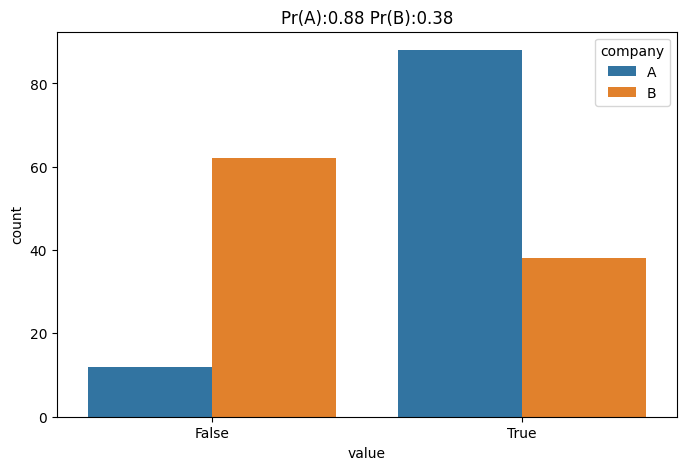

In [22]:
np.mean( A_causality)
np.mean( B_causality)

comb = A_causality + B_causality
data = {"company": ["A"]*100 + ["B"]*100, "value": comb}
df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='value', hue='company')

ax.set_title('Pr(A):' +  str(np.mean( A_causality)) +
                " Pr(B):" + str(np.mean( B_causality))
                 )

plt.show()


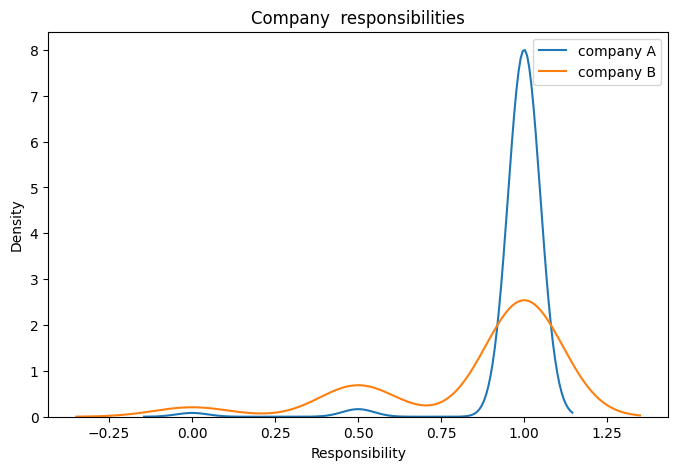

In [278]:

fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(data=A_responsibility, ax=ax, label='company A')

sns.kdeplot(data=B_responsibility, ax=ax, label='company B')

ax.set_xlabel('Responsibility')
ax.set_ylabel('Density')
ax.set_title('Company  responsibilities')

ax.legend()

plt.show()
